In [1]:
%run 4.fusion.ipynb

Aresta [-55, 2, 17, 0.3] -> Classe 1 (Bom) (confiança 1.00)
Aresta [-85, 3.8, 30, 0.1] -> Classe 1 (Bom) (confiança 0.66)
Aresta [-35, 1.2, 5, 0.05] -> Classe 1 (Bom) (confiança 1.00)
Aresta [-88, 9.5, 95, 0.9] -> Classe 0 (Ruim) (confiança 1.00)
Aresta [-40, 8.2, 85, 0.8] -> Classe 0 (Ruim) (confiança 1.00)
Aresta [-87, 1.5, 8, 0.15] -> Classe 1 (Bom) (confiança 0.99)
Aresta [-62, 2.8, 32, 0.28] -> Classe 1 (Bom) (confiança 0.96)
Aresta [-58, 3.2, 28, 0.32] -> Classe 1 (Bom) (confiança 0.96)
Aresta [-52, 2.1, 20, 0.25] -> Classe 1 (Bom) (confiança 1.00)
Aresta [-48, 2.5, 25, 0.22] -> Classe 1 (Bom) (confiança 1.00)
Aresta [-50, 1.8, 22, 0.28] -> Classe 1 (Bom) (confiança 1.00)
Aresta [-75, 5.2, 65, 0.6] -> Classe 0 (Ruim) (confiança 1.00)
Aresta [-78, 4.8, 70, 0.65] -> Classe 0 (Ruim) (confiança 1.00)
Aresta [-72, 5.5, 60, 0.58] -> Classe 0 (Ruim) (confiança 1.00)
Aresta [-45, 4.5, 15, 0.7] -> Classe 0 (Ruim) (confiança 0.56)
Aresta [-70, 1.9, 45, 0.2] -> Classe 1 (Bom) (confiança 0.9


=== Comparação por Aresta ===


,Aresta,Verdadeiro,MLP_Prob,MLP_Classe,Fusao_Prob,Fusao_Classe,Kalman_Prob,Kalman_Classe
0,"[-55, 2, 17, 0.3]",Bom,0.996836,Bom,0.907824,Bom,0.863830,Bom
1,"[-85, 3.8, 30, 0.1]",Bom,0.664352,Bom,0.583333,Bom,0.748208,Bom
2,"[-35, 1.2, 5, 0.05]",Bom,0.999988,Bom,0.981938,Bom,0.907865,Bom
3,"[-88, 9.5, 95, 0.9]",Ruim,0.000001,Ruim,0.018890,Ruim,0.479656,Ruim
4,"[-40, 8.2, 85, 0.8]",Ruim,0.000369,Ruim,0.175221,Ruim,0.349766,Ruim
...,...,...,...,...,...,...,...,...
65,"[-89, 9.0, 90, 0.9]",Ruim,0.000002,Ruim,0.030279,Ruim,0.301543,Ruim
66,"[-44, 7.5, 12, 0.15]",Bom,0.890158,Bom,0.718539,Bom,0.449357,Ruim
67,"[-83, 1.8, 78, 0.75]",Ruim,0.001883,Ruim,0.246408,Ruim,0.370300,Ruim
68,"[-38, 6.8, 8, 0.82]",Ruim,0.066085,Ruim,0.258540,Ruim,0.327796,Ruim



=== Métricas - MLP ===
              precision    recall  f1-score   support

        Ruim       1.00      1.00      1.00        31
         Bom       1.00      1.00      1.00        39

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70

Acurácia: 1.0

=== Métricas - Fusão Espacial ===
              precision    recall  f1-score   support

        Ruim       1.00      0.94      0.97        31
         Bom       0.95      1.00      0.97        39

    accuracy                           0.97        70
   macro avg       0.98      0.97      0.97        70
weighted avg       0.97      0.97      0.97        70

Acurácia: 0.9714285714285714

=== Métricas - Fusão + Kalman ===
              precision    recall  f1-score   support

        Ruim       0.90      0.84      0.87        31
         Bom       0.88      0.92      0.90        39

    accuracy                           0.89  

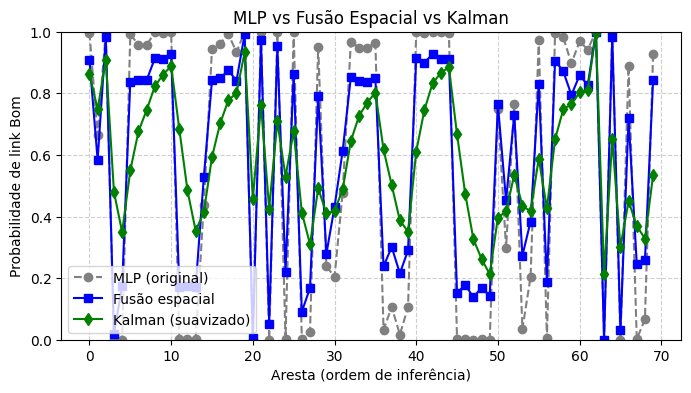

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# ============================================================
# 2) Definição do Kalman 1D
# ============================================================
def logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class Kalman1D:
    def __init__(self, Q=0.05, R=0.25):
        self.Q = Q
        self.R = R
        self.z_est = 0.0
        self.P = 1.0
    def update(self, p_now):
        y = logit(p_now)
        z_pred = self.z_est
        P_pred = self.P + self.Q
        K = P_pred / (P_pred + self.R)
        self.z_est = z_pred + K * (y - z_pred)
        self.P = (1 - K) * P_pred
        return sigmoid(self.z_est)

# ============================================================
# 3) Aplicar Kalman
# ============================================================
kf = Kalman1D(Q=0.05, R=0.25)
fusion_kalman = [kf.update(p) for p in fusion_scores]

# ============================================================
# 4) Classes finais
# ============================================================
tau = 0.5
y_true = preds.numpy()
y_pred_mlp = (probs[:, 1].numpy() >= tau).astype(int)
y_pred_fusion = (np.array(fusion_scores) >= tau).astype(int)
y_pred_kalman = (np.array(fusion_kalman) >= tau).astype(int)

CLASS_NAMES = {0: "Ruim", 1: "Bom"}

# ============================================================
# 5) DataFrame comparativo
# ============================================================
df_compare = pd.DataFrame({
    "Aresta": [str(r) for r in test_data],
    "Verdadeiro": [CLASS_NAMES[y] for y in y_true],
    "MLP_Prob": probs[:, 1].numpy(),
    "MLP_Classe": [CLASS_NAMES[c] for c in y_pred_mlp],
    "Fusao_Prob": fusion_scores,
    "Fusao_Classe": [CLASS_NAMES[c] for c in y_pred_fusion],
    "Kalman_Prob": fusion_kalman,
    "Kalman_Classe": [CLASS_NAMES[c] for c in y_pred_kalman],
})

print("\n=== Comparação por Aresta ===")
display(df_compare)

# ============================================================
# 6) Métricas de desempenho
# ============================================================
print("\n=== Métricas - MLP ===")
print(classification_report(y_true, y_pred_mlp, target_names=["Ruim", "Bom"]))
print("Acurácia:", accuracy_score(y_true, y_pred_mlp))

print("\n=== Métricas - Fusão Espacial ===")
print(classification_report(y_true, y_pred_fusion, target_names=["Ruim", "Bom"]))
print("Acurácia:", accuracy_score(y_true, y_pred_fusion))

print("\n=== Métricas - Fusão + Kalman ===")
print(classification_report(y_true, y_pred_kalman, target_names=["Ruim", "Bom"]))
print("Acurácia:", accuracy_score(y_true, y_pred_kalman))

# ============================================================
# 7) Gráfico comparativo
# ============================================================
plt.figure(figsize=(8,4))
plt.plot(probs[:, 1].numpy(), 'o--', label="MLP (original)", color="gray")
plt.plot(fusion_scores, 's-', label="Fusão espacial", color="blue")
plt.plot(fusion_kalman, 'd-', label="Kalman (suavizado)", color="green")
plt.title("MLP vs Fusão Espacial vs Kalman")
plt.xlabel("Aresta (ordem de inferência)")
plt.ylabel("Probabilidade de link Bom")
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()